# **Diamonds Exploratory Data Analysis**
**4C's - Carat, Clarity, Colour and Cut**

![imgs](https://i.pinimg.com/736x/ee/20/82/ee208232377a87b77968813534eb707a.jpg)



In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from utils import get_path

## Loading and Preprocessing

In [2]:
data_dir = get_path("Data/diamonds.csv")
df = pd.read_csv(data_dir).drop(columns='Unnamed: 0')
print(df.dtypes)
df

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


In [5]:
def preprocess_data(df, exchange_rate=13.5):
    """
    Preprocess the diamond DataFrame with the following steps:
    - Convert:  price [ USD -> BWP] 
                float32 
                categorical columns to category dtype
    - add 'volume' feature from the dimensions x, y, z
    """
    
    df['price_bwp'] = (df['price'] * exchange_rate).round(2)
    
    numeric_cols = ['carat', 'depth', 'table', 'x', 'y', 'z', 'price']
    df[numeric_cols] = df[numeric_cols].astype('float32')
    
    categorical_cols = ['cut', 'color', 'clarity']
    df[categorical_cols] = df[categorical_cols].apply(lambda col: col.astype('category'))
    
    # Create volume feature
    df['volume'] = (df['x'] * df['y'] * df['z']).astype('float32')
    
    # drop other
    df = df.drop(columns=['x', 'y', 'z', 'price'])
    
    # summary info
    print("\nOptimized df:")
    print(df.info())
    print("\nSample Data:")
    print(df.head())

    
    return df
df_processed = preprocess_data(df)


Optimized df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   carat      53940 non-null  float32 
 1   cut        53940 non-null  category
 2   color      53940 non-null  category
 3   clarity    53940 non-null  category
 4   depth      53940 non-null  float32 
 5   table      53940 non-null  float32 
 6   price_bwp  53940 non-null  float32 
 7   volume     53940 non-null  float32 
dtypes: category(3), float32(5)
memory usage: 1.2 MB
None

Sample Data:
   carat      cut color clarity      depth  table  price_bwp     volume
0   0.23    Ideal     E     SI2  61.500000   55.0     4401.0  38.202034
1   0.21  Premium     E     SI1  59.799999   61.0     4401.0  34.505856
2   0.23     Good     E     VS1  56.900002   65.0     4414.5  38.076889
3   0.29  Premium     I     VS2  62.400002   58.0     4509.0  46.724579
4   0.31     Good     J     SI2  63

## handling missingless and outliers 

1. remove 0 volume this doesnt make sense
2. outliers

In [6]:
df_filtered = df_processed[df_processed['volume'] != 0]

lets look at the outlier if any

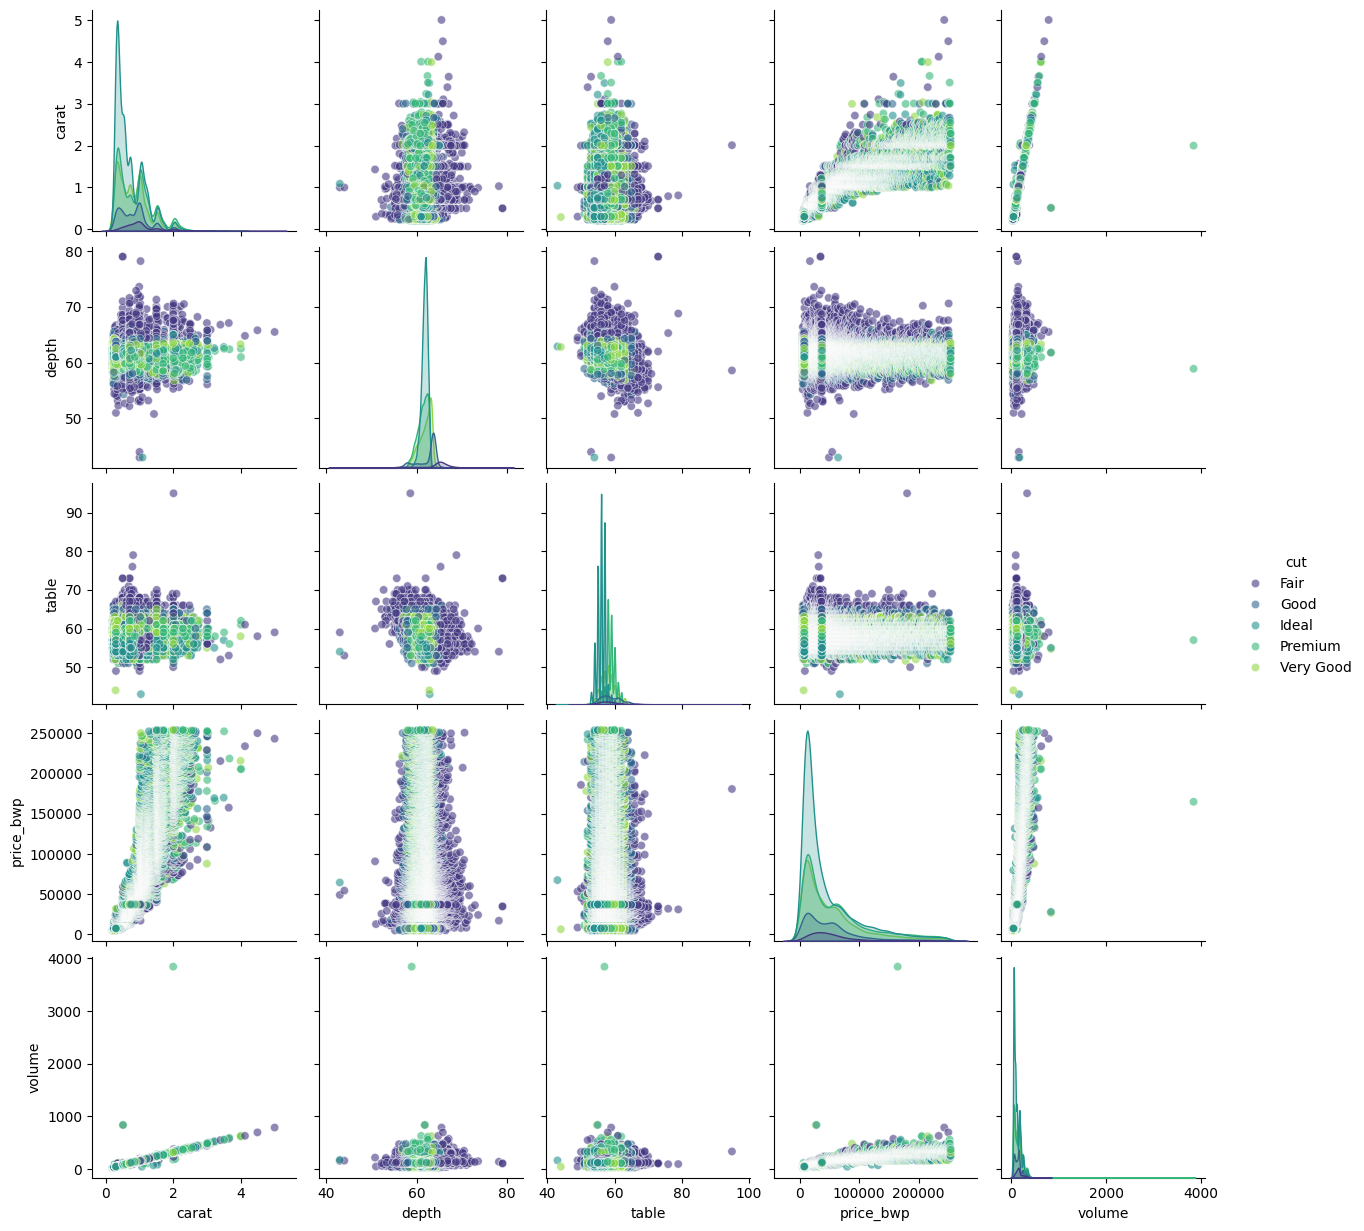

In [9]:
sns.pairplot(df_filtered, 
             hue='cut', palette='viridis', plot_kws={'alpha':0.6})

some obvious outliers... lets take of them.

In [7]:

def remove_outliers_iqr(df, factor=1.5):
    """Remove outliers from numeric columns using IQR """

    numeric_cols = df.select_dtypes(include=[np.number]).columns

    # Calculate IQR
    Q1 = df[numeric_cols].quantile(0.25)
    Q3 = df[numeric_cols].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    
    # Filter rows
    mask = ((df[numeric_cols] >= lower_bound) & 
            (df[numeric_cols] <= upper_bound)).all(axis=1)
    
    return df[mask]



df_clean = remove_outliers_iqr(df_filtered, 2)
print(f"Original shape: {df_processed.shape}")
print(f"filtered shape: {df_filtered.shape}")
print(f"Cleaned shape: {df_clean.shape}")


Original shape: (53940, 8)
filtered shape: (53920, 8)
Cleaned shape: (50539, 8)


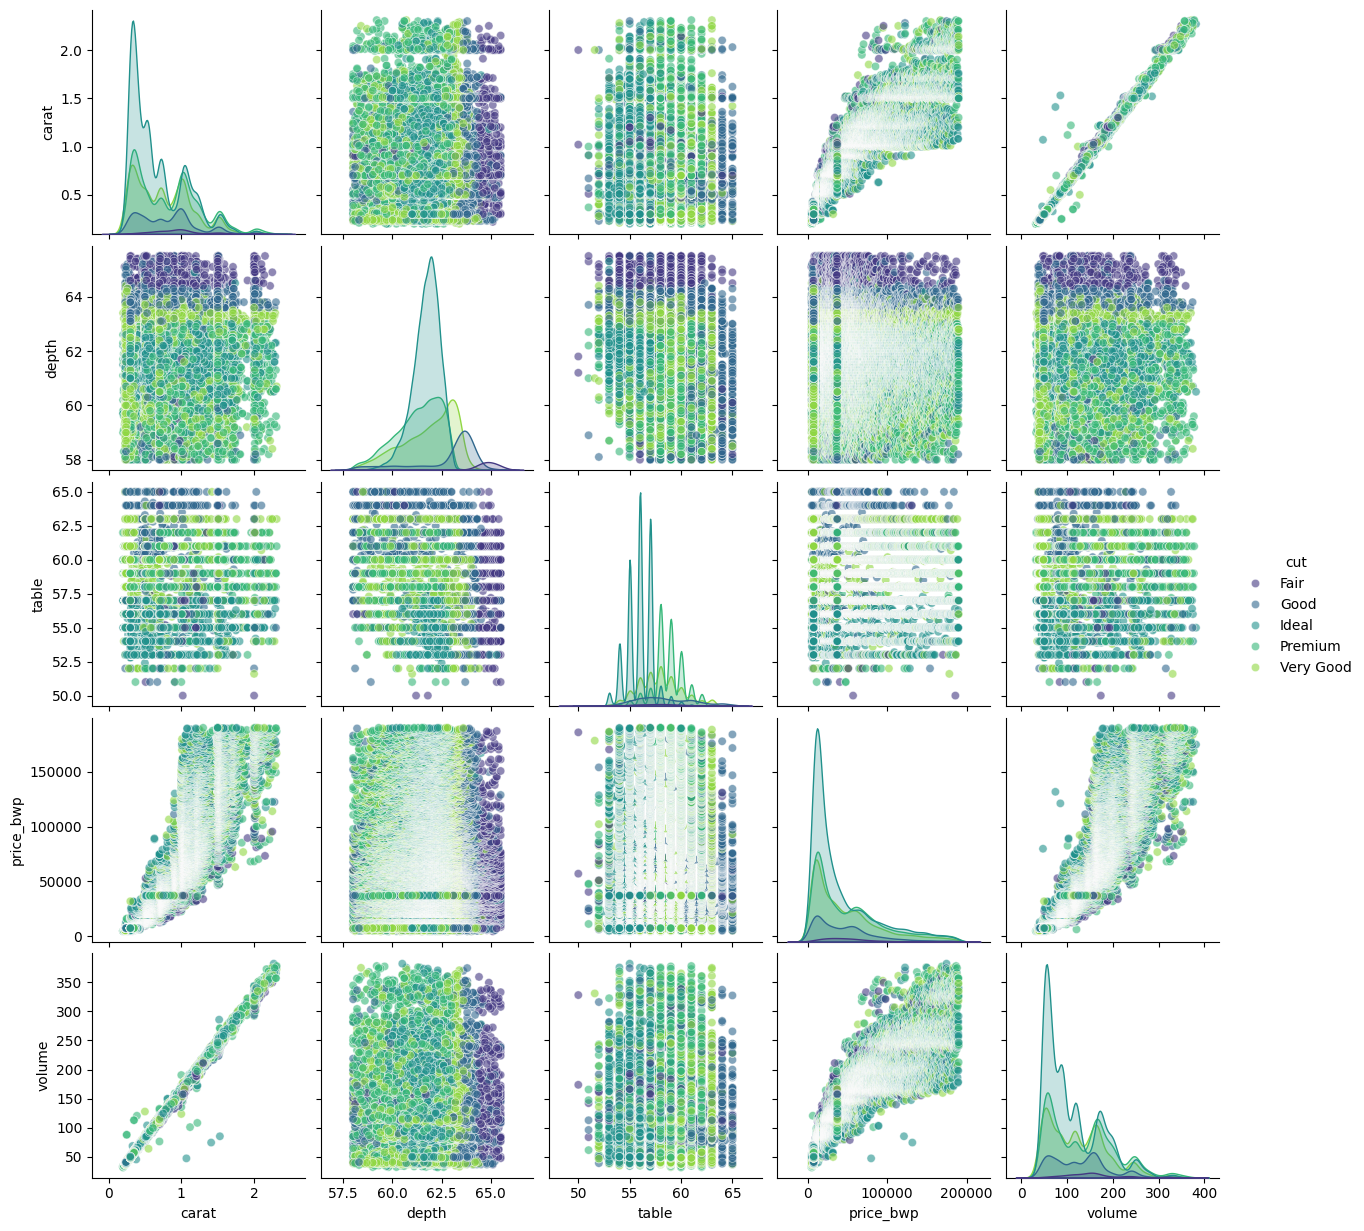

In [8]:
sns.pairplot(df_clean,
             hue='cut', palette='viridis', plot_kws={'alpha':0.6})

its a much better cleaner df

## Basic Statistics & Distributions

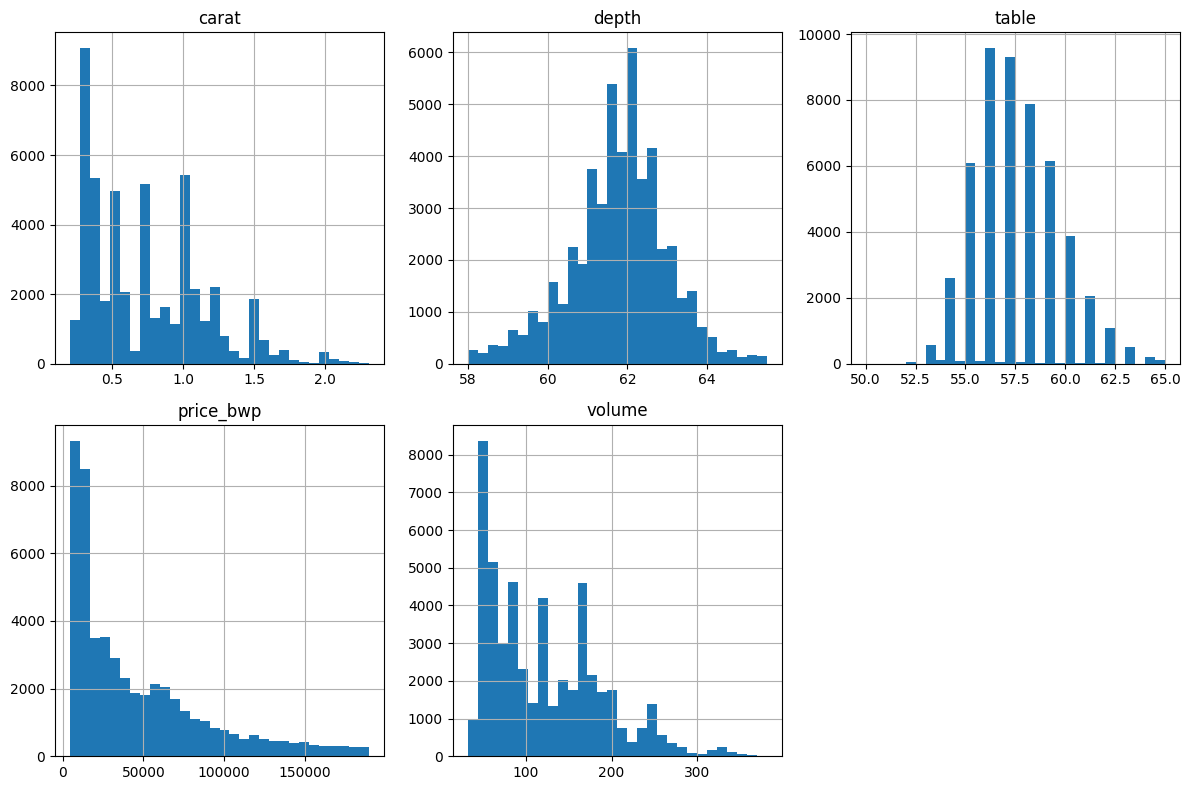

In [9]:
df_clean.hist(bins=30, figsize=(12, 8), layout=(2, 3))
plt.tight_layout()
plt.show()

* price skewed, makes sense,
* depth and table normal distributed, 
* volume multimodal

# Multivariate Analysis

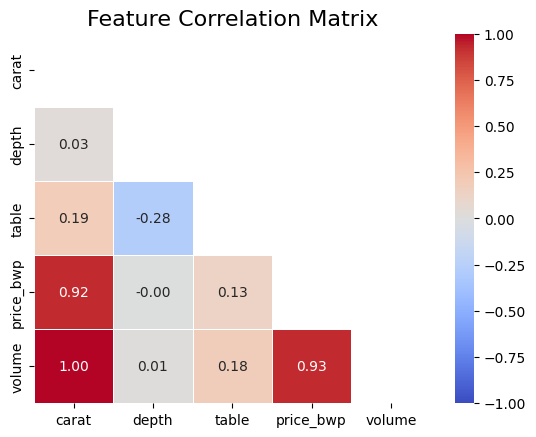

In [10]:
# Correlation matrix
corr = df_clean.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))


sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', 
            vmin=-1, vmax=1, linewidths=0.5)
plt.title('Feature Correlation Matrix', fontsize=16)
plt.show()


**Price variation across categories**

In [11]:
categorical_cols = df_clean.select_dtypes("category")
for col in categorical_cols:
    print(f"\nPrice statistics by {col}:")
    print(df_clean.groupby(col,observed=True)['price_bwp'].describe())


Price statistics by cut:
             count          mean           std     min        25%       50%  \
cut                                                                           
Fair         759.0  54868.433594  38285.683594  4549.5  28215.000  46197.00   
Good        4351.0  46807.296875  39194.441406  4522.5  14073.750  37746.00   
Ideal      20862.0  41009.843750  41322.742188  4401.0  11691.000  23382.00   
Premium    12991.0  52407.339844  45472.949219  4401.0  13648.500  37962.00   
Very Good  11576.0  47103.613281  42089.796875  4536.0  11876.625  33689.25   

                75%       max  
cut                            
Fair       69099.75  187015.5  
Good       63848.25  189364.5  
Ideal      57402.00  189958.5  
Premium    75836.25  189958.5  
Very Good  67189.50  189958.5  

Price statistics by color:
         count          mean           std     min        25%       50%  \
color                                                                     
D       6502.0  38

---

## Key Insights from EDA:

1. **Correlations**:
   - strong corelation between price , carat and volume, not suprising.
   - medium corelation between depth and table , others not so significant

2. **Quality Characteristics**:
   - Cut: Most diamonds are "Ideal" or "Premium" cut
   - Color: G and H colors are most common
   - Clarity: SI1 and VS2 clarity grades dominate the dataset

3. **Important Relationships**:
   - Carat has the strongest correlation with price (r=0.92)
   - Higher quality grades (better cut, better color, better clarity) command higher prices per carat
   - Volume shows a slightly stronger correlation with price than individual dimensions

4. **Unexpected Findings**:
   - Premium cut diamonds have higher median prices than Ideal cuts
   - J color diamonds have higher prices than I color due to larger average size
   - Depth between 58-64% and table between 53-59% are most common



## Lets throw classical models at it; 

In [ ]:
import pickle
from sklearn.model_selection import train_test_split

# Ensure your data is in a Pandas DataFrame and not the special AutoGluon TabularDataset yet
train, test = train_test_split(df_clean, test_size=0.2, random_state=7) 

clean_ds = {"train": train,
            "test": test
            }

save_dir = get_path("Data/clean_ds.plk") 

#serialise and save cleaned data
with open(save_dir, "wb") as f:
    pickle.dump(clean_ds, f)

TabNet Regressor Results ---

R-squared (R²): 0.8757

Mean Absolute Error (MAE): 8983.45 BWP

Root Mean Squared Error (RMSE): 14946.71 BWP

In [5]:
import pickle

with open("cleandata.pkl", 'rb') as f:
    data = pickle.load(f)
data

{'df_clean':        carat        cut color clarity      depth  table  price_bwp      volume
 0       0.23      Ideal     E     SI2  61.500000   55.0     4401.0   38.202034
 1       0.21    Premium     E     SI1  59.799999   61.0     4401.0   34.505856
 3       0.29    Premium     I     VS2  62.400002   58.0     4509.0   46.724579
 4       0.31       Good     J     SI2  63.299999   58.0     4522.5   51.917248
 5       0.24  Very Good     J    VVS2  62.799999   57.0     4536.0   38.693954
 ...      ...        ...   ...     ...        ...    ...        ...         ...
 53935   0.72      Ideal     D     SI1  60.799999   57.0    37219.5  115.920013
 53936   0.72       Good     D     SI1  63.099998   55.0    37219.5  118.110168
 53937   0.70  Very Good     D     SI1  62.799999   60.0    37219.5  114.449722
 53938   0.86    Premium     H     SI2  61.000000   58.0    37219.5  140.766129
 53939   0.75      Ideal     D     SI2  62.200001   55.0    37219.5  124.568443
 
 [50539 rows x 8 columns],